# Parameter space scan

In [51]:
import matplotlib.pyplot as plt
import pandas as pd
import re

plt.rcParams.update({'font.size': 14, 
                    'xtick.labelsize':14,
                    'ytick.labelsize':14,
                    'axes.labelsize': 14,
                    'axes.titlesize':14})


In [3]:
def get_count(x,true_false):
    my_sum=0
    for i in x:
        if i == true_false:
            my_sum+=1
    return my_sum



def plot_param_space(filename):
    
    #load the data
    df = pd.read_csv(filename)
    
    #get total number of simulations
    number_simulations = len(df['loop_step'].unique())
    
    #get columns containing true/false/not_all_assigned
    guac_cols = [col for col in df.columns if 'guac_' in col]

    #make it a string
    for gc in guac_cols:
        df[gc] = df[gc].apply(lambda x: str(x).lower())

    #create a 3x3 grid to contain different standard deviations and and different assumptions 
    #about town people counts
    nrows=3
    ncols=3
    fig, axes = plt.subplots(nrows, ncols, figsize=(12,12), sharex=True, sharey=True)

    #extract the scenario from the filename
    scenarios = ['a-close-call', 'a-lot-of-contenders', 'one-clear-winner']
    for scenario in scenarios:
        if scenario in filename: break
            
    if 'fullness_factor' in filename:
        scenario = scenario + ', fullness_factor=1'
        
    if 'condorcet_' in filename:
        scenario = scenario + ', winner by condorcet'

    if 'sum_' in filename:
        scenario = scenario + ', winer by sum'
        
    print(scenario)
        
    

    #loop over standard deviations
    counter_std = 0
    for std in df['standard_dev'].unique():
        df_std = df[df['standard_dev']==std].copy()

        #loop over number of townpeople
        counter_nt = 0
        for nt in df['number_town_people'].unique():
            
            df_nt = df_std[df_std['number_town_people'] == nt].copy()
            df_nt.set_index(['loop_step'], inplace = True)
            df_nt = df_nt[guac_cols].copy()

            #transpose it to count the different options
            df_ntt = df_nt.T        
            df_ntt['num_true'] = df_ntt.apply(lambda x: 100.*get_count(x,'true')/number_simulations,1)
            df_ntt['num_false'] = df_ntt.apply(lambda x: 100.*get_count(x,'false')/number_simulations,1)
            df_ntt['num_not_all_assigned'] = df_ntt.apply(lambda x: 100.*get_count(x,'not_all_assigned')/number_simulations,1)

            df_ntt['guac_id'] = df_ntt.index
            df_ntt['guac_id'] = df_ntt['guac_id'].apply(lambda x: int(x.split('_')[-1]))

            #plot the different configurations as stacked bar plots
            axes[counter_nt,counter_std].bar(df_ntt['guac_id'].tolist(), 
                                             df_ntt['num_true'].tolist(), 
                                             color = 'teal', 
                                             label = 'winner recovered'
                                            )
            axes[counter_nt,counter_std].bar(df_ntt['guac_id'].tolist(), 
                                             df_ntt['num_false'].tolist(), 
                                             bottom = df_ntt['num_true'].tolist(), 
                                             color = 'orange', 
                                             label = 'winner not recovered'
                                            )
            axes[counter_nt,counter_std].bar(df_ntt['guac_id'], 
                                             df_ntt['num_not_all_assigned'], 
                                             bottom = df_ntt['num_true'] + df_ntt['num_false'], 
                                             color = 'red', 
                                             label = 'not all guacs assigned'
                                            )
            #fix the limit on the y axis to allow comparisons
            axes[counter_nt,counter_std].set_ylim(0, 120)
            
            #add parameters to the figure
            if counter_nt == 0 and counter_std == 1:
                axes[counter_nt,counter_std].set_title(f"{scenario}\n\nTownpeople = {nt}, std = {std}")
            else:
                axes[counter_nt,counter_std].set_title(f"Townpeople = {nt}, std = {std}")

            #add legend
            axes[counter_nt,counter_std].legend(loc=4, fontsize=12)

            #add labels
            if counter_std == 0:
                axes[counter_nt,counter_std].set_ylabel('%')
            if counter_nt == ncols-1:
                axes[counter_nt,counter_std].set_xlabel('# guacs tasted')

            counter_nt+=1
        counter_std+=1
    plt.subplots_adjust(left=0.1,
                        bottom=0.1, 
                        right=0.9, 
                        top=0.9, 
                        wspace=0.1, 
                        hspace=0.2)  
    plt.savefig(f"../plots/{re.sub('.csv', '', f.split('/')[-1])}_viz.png")

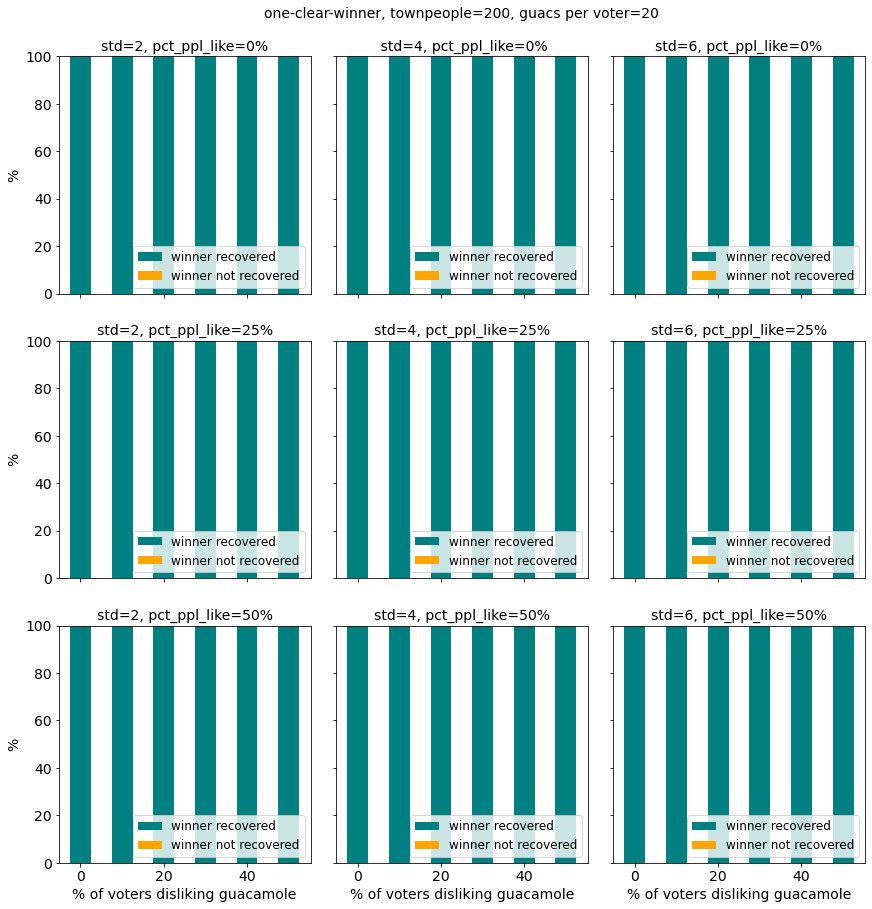

In [57]:
# param_space_scan_totalSim100_a-close-call_sum.csv
# param_space_scan_totalSim100_a-lot-of-contenders_sum.csv
# param_space_scan_totalSim100_one-clear-winner_sum.csv
this_scenario = 'a-lot-of-contenders'
this_scenario = 'one-clear-winner'
filename = f"../data/param_space_scan_totalSim100_{this_scenario}_sum.csv"

#load the data
df = pd.read_csv(filename)

df.head()
#convert to string column with winner recovery info
df['true_winner_recovered'] = df['true_winner_recovered'].apply(lambda x: str(x).lower())


#considering 1 specific metric and scenario
this_metric = 'sum'
num_townspeople = df['num_townspeople'].tolist()[0]
num_guacs_per_voter = df['num_guacs_per_voter'].tolist()[0]

df = df[df['metric'] == this_metric]
df = df[df['scenario'] == this_scenario]

#create figure grid
nrows=3
ncols=3
fig, axes = plt.subplots(nrows, ncols, figsize=(14,14), sharex=True, sharey=True)


#loop over all std
counter_std = 0
for std in sorted(df['std'].unique()):
    
    #loop over all percentages of people liking guac
    counter_ppl = 0
    for ppl in sorted(df['pct_ppl_like'].unique()):
        
        #slice by dimensions and extract the quantities of interest
        df1 = df[df['pct_ppl_like'] == ppl]
        df1 = df1[df1['std'] == std][['pct_ppl_dislike', 'true_winner_recovered']]
        
        
        #create lists with counts of true and false for each value of pct_ppl_dislike for plotting
        ppd_list = sorted(df1['pct_ppl_dislike'].unique())
        true_list, false_list = [], []
        for ppd in ppd_list:
            df2 = df1[df1['pct_ppl_dislike'] == ppd]
            true_list.append(len(df2[df2['true_winner_recovered'] == 'true']))
            false_list.append(len(df2[df2['true_winner_recovered'] == 'false']))                      

        #plot the data
        my_width = 5
        axes[counter_ppl,counter_std].bar(ppd_list,true_list,label = 'winner recovered', color = 'teal', width = my_width)
        axes[counter_ppl,counter_std].bar(ppd_list,false_list,bottom=true_list, color = 'orange', label = 'winner not recovered', width = my_width)
        
        #add title and labels
        if counter_ppl == 0 and counter_std == 1:
            axes[counter_ppl,counter_std].set_title(f"{this_scenario}, townpeople={num_townspeople}, guacs per voter={num_guacs_per_voter}\n\n std={std}, pct_ppl_like={ppl}%")
        else:
            axes[counter_ppl,counter_std].set_title(f"std={std}, pct_ppl_like={ppl}%")
        
        if counter_ppl == nrows-1:
            axes[counter_ppl,counter_std].set_xlabel('% of voters disliking guacamole')

        if counter_std == 0:
            axes[counter_ppl,counter_std].set_ylabel('%')
            
        #add legend
        axes[counter_ppl,counter_std].legend(loc=4, fontsize=12)
                
        counter_ppl += 1
    counter_std += 1

    
plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.1, 
                    hspace=0.2)  
plt.savefig(f"plots/{re.sub('.csv', '', filename.split('/')[-1])}_viz.png")

a-close-call, fullness_factor=1, winner by condorcet


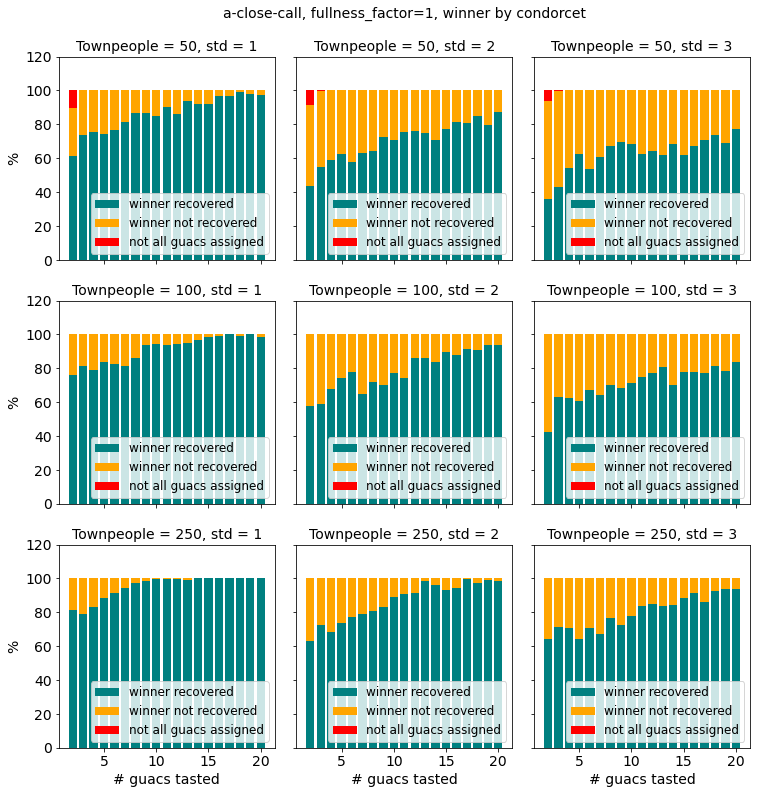

In [6]:


# condorcet_param_space_for_recovering_winner_total_guacs20_one-clear-winner_20220318.csv

files = [
    f"../data/condorcet_param_space_for_recovering_winner_total_guacs20_a-close-call_fullness_factor_20220318.csv", 
#     f"../data/sum_param_space_for_recovering_winner_total_guacs20_a-close-call_fullness_factor_20220318.csv", 
#     f"../data/condorcet_param_space_for_recovering_winner_total_guacs20_a-lot-of-contenders_fullness_factor_20220318.csv", 
#     f"../data/sum_param_space_for_recovering_winner_total_guacs20_a-lot-of-contenders_fullness_factor_20220318.csv", 
#     f"../data/condorcet_param_space_for_recovering_winner_total_guacs20_one-clear-winner_fullness_factor_20220318.csv", 
#     f"../data/sum_param_space_for_recovering_winner_total_guacs20_one-clear-winner_fullness_factor_20220318.csv"
]

for f in files:
    plot_param_space(f)
